Import Library

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import drive, files

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_dir = "/content/drive/Shareddrives/LeafCheck_Capstone/dataset 3/train"
test_dir = "/content/drive/Shareddrives/LeafCheck_Capstone/dataset 3/test"

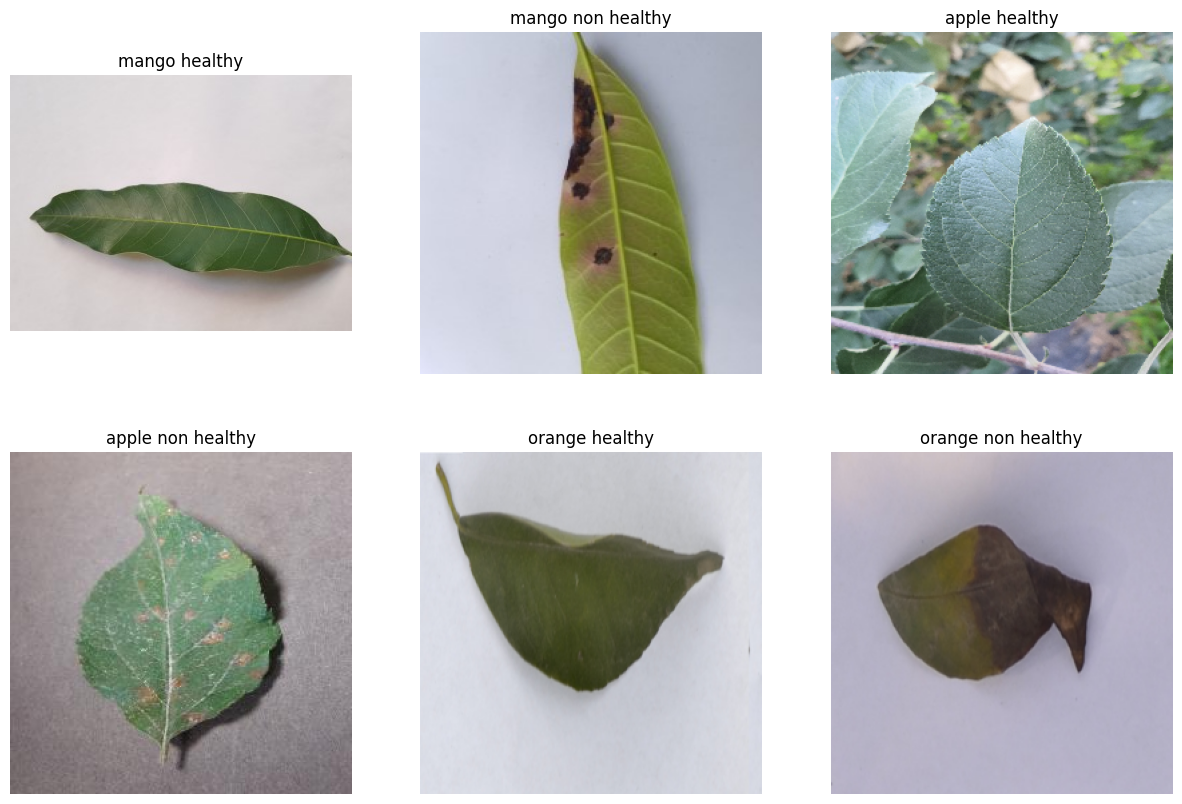

In [5]:
# Function to display a few images from each class
def display_sample_images():
    categories = ["mango healthy", "mango non healthy", "apple healthy", "apple non healthy", "orange healthy", "orange non healthy"]
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    for category, ax in zip(categories, axes.flatten()):
        image_path = os.path.join(train_dir, category, os.listdir(os.path.join(train_dir, category))[0])
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.set_title(category)
        ax.axis('off')

    plt.show()

display_sample_images()

In [6]:
# Data generators
def cutout(img, mask_size):
    h, w, _ = img.shape
    mask_value = img.mean()

    top = np.random.randint(0, h - mask_size)
    left = np.random.randint(0, w - mask_size)
    bottom = top + mask_size
    right = left + mask_size

    img[top:bottom, left:right, :] = mask_value

    return img

def train_test_generators(train_dir, test_dir):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
        preprocessing_function=lambda img: cutout(img, mask_size=16)
    )

    train_generator = train_datagen.flow_from_directory(
        directory=train_dir,
        batch_size=32,
        class_mode="categorical",
        target_size=(150, 150)
    )

    test_datagen = ImageDataGenerator(rescale=1/255)

    test_generator = test_datagen.flow_from_directory(
        directory=test_dir,
        batch_size=32,
        class_mode="categorical",
        target_size=(150, 150)
    )

    return train_generator, test_generator


In [7]:
train_generator, test_generator = train_test_generators(train_dir, test_dir)

Found 1880 images belonging to 6 classes.
Found 500 images belonging to 6 classes.


In [ ]:
#from tensorflow.keras.applications.inception_v3 import InceptionV3

In [8]:
# Model creation
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

##Training Model

In [11]:
class EarlyStop(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95 and logs.get('val_accuracy')>0.95):
      print("\nModel have reached 96%")
      self.model.stop_training = True


In [13]:
callbacks = EarlyStop()
# Training the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=50, callbacks= callbacks
)

Epoch 1/50
59/59 [==============================] - 72s 1s/step - loss: 0.1510 - accuracy: 0.9489 - val_loss: 0.1807 - val_accuracy: 0.9360
Epoch 2/50
59/59 [==============================] - 69s 1s/step - loss: 0.1641 - accuracy: 0.9378 - val_loss: 0.6550 - val_accuracy: 0.8560
Epoch 3/50
59/59 [==============================] - 71s 1s/step - loss: 0.1697 - accuracy: 0.9415 - val_loss: 0.3306 - val_accuracy: 0.9200
Epoch 4/50
59/59 [==============================] - 72s 1s/step - loss: 0.1318 - accuracy: 0.9511 - val_loss: 0.4477 - val_accuracy: 0.8900
Epoch 5/50
59/59 [==============================] - 71s 1s/step - loss: 0.1383 - accuracy: 0.9479 - val_loss: 0.4723 - val_accuracy: 0.9200
Epoch 6/50
59/59 [==============================] - 70s 1s/step - loss: 0.1495 - accuracy: 0.9473 - val_loss: 0.4089 - val_accuracy: 0.9120
Epoch 7/50
59/59 [==============================] - 72s 1s/step - loss: 0.1469 - accuracy: 0.9537 - val_loss: 0.5322 - val_accuracy: 0.8860
Epoch 8/50
59/59 [==

##Model evaluate

In [14]:
# Evaluation
train_loss, train_acc = model.evaluate(train_generator)
print('Train Accuracy', train_acc)

val_loss, val_acc = model.evaluate(test_generator)
print('Validation Accuracy', val_acc)

59/59 [==============================] - 37s 633ms/step - loss: 0.0780 - accuracy: 0.9702
Train Accuracy 0.9702127575874329
16/16 [==============================] - 8s 467ms/step - loss: 0.1079 - accuracy: 0.9580
Validation Accuracy 0.9580000042915344


In [15]:
history.history

{'loss': [0.15098734200000763,
  0.16412299871444702,
  0.1696784496307373,
  0.13181498646736145,
  0.1382988840341568,
  0.14946509897708893,
  0.14687347412109375,
  0.16170498728752136,
  0.1545066088438034,
  0.1308024376630783,
  0.17020484805107117,
  0.12240985035896301,
  0.1528984010219574,
  0.13865821063518524],
 'accuracy': [0.9489361643791199,
  0.9377659559249878,
  0.9414893388748169,
  0.9510638117790222,
  0.9478723406791687,
  0.9473404288291931,
  0.9537234306335449,
  0.9414893388748169,
  0.9457446932792664,
  0.9468085169792175,
  0.9404255151748657,
  0.9505318999290466,
  0.9542553424835205,
  0.9515957236289978],
 'val_loss': [0.180721715092659,
  0.6549651622772217,
  0.33056989312171936,
  0.4477396309375763,
  0.4722944498062134,
  0.4088992178440094,
  0.5321874618530273,
  0.6920236349105835,
  0.6516568660736084,
  0.09779976308345795,
  0.287108451128006,
  0.7617212533950806,
  0.44409438967704773,
  0.1079333946108818],
 'val_accuracy': [0.93599998950

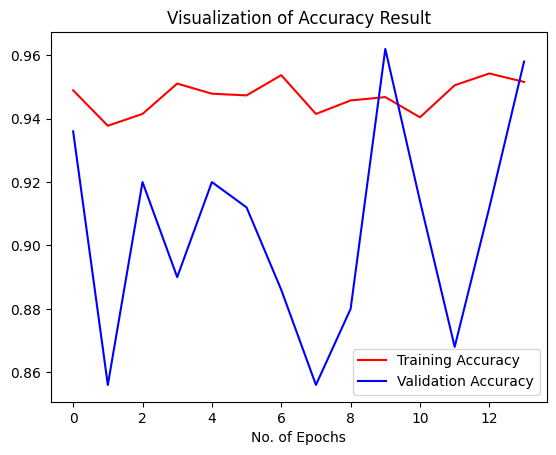

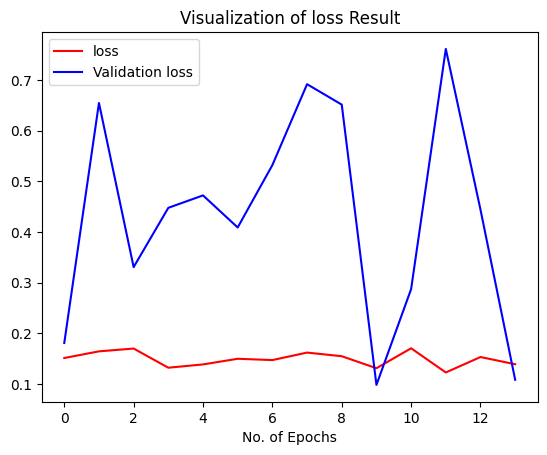

In [16]:
# Plotting accuracy
plt.plot(history.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()


# Plotting los
plt.plot(history.history['loss'], color='red', label='loss')
plt.plot(history.history['val_loss'], color='blue', label='Validation loss')
plt.xlabel('No. of Epochs')
plt.title('Visualization of loss Result')
plt.legend()
plt.show()

In [17]:
model.save('Pred_model_FIX0.95.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##Model Prediction

Saving 20211011_134719 (Custom).jpg to 20211011_134719 (Custom).jpg
1/1 [==============================] - 0s 155ms/step
[4.3671768e-12 1.1594884e-09 2.2143180e-08 9.9999988e-01 1.0929207e-19
 7.5291865e-08]
20211011_134719 (Custom).jpg is unhealthy mango leaves


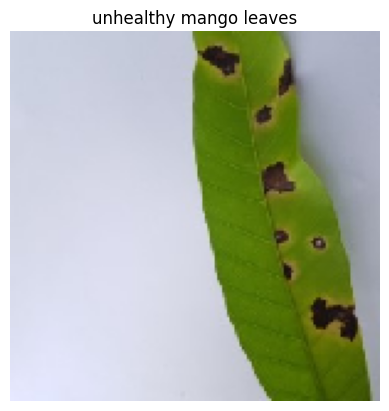

In [18]:
upload = files.upload()

for fn in upload.keys():
    path = '/content/' + fn
    img = load_img(path, target_size=(150, 150))
    x = img_to_array(img)
    x /= 255.0
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    predicted_class = np.argmax(classes[0])


    if predicted_class == 0:
        label = "healthy apple leaves"
    elif predicted_class == 1:
        label = "unhealthy apple leaves"
    elif predicted_class == 2:
        label = "healthy mango leaves"
    elif predicted_class == 3:
        label = "unhealthy mango leaves"
    elif predicted_class == 4:
        label = "healthy orange leaves"
    elif predicted_class == 5:
        label = "unhealthy orange leaves"

    print(fn + " is " + label)

    # Plot the image
    plt.imshow(load_img(path, target_size=(150, 150)))
    plt.axis('off')
    plt.title(f'{label}')
    plt.show()